In this notebook, we:
- Load and preprocess a loan approval dataset
- Build two models: K-Nearest Neighbors (KNN) and Decision Tree
- Evaluate them with accuracy, precision, recall, and F1-score
- Compare performance and inspect feature importance for insights

In [ ]:
# import required librarires 

%pip install seaborn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# For nice plots
sns.set(style="whitegrid", font_scale=1.1)

In [14]:
# load the file and view details

file_path = "data/loan_approval_dataset.csv"

df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

df.head()

Shape: (4269, 13)

Columns:
 Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'credit_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,credit_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [4]:
TARGET_COLUMN = "loan_status"

if TARGET_COLUMN not in df.columns:
    raise ValueError(f"TARGET_COLUMN '{TARGET_COLUMN}' not found in columns: {list(df.columns)}")

# Drop rows where target is missing
df = df.dropna(subset=[TARGET_COLUMN])

print("Shape after dropping missing target rows:", df.shape)
df[TARGET_COLUMN].value_counts()

Shape after dropping missing target rows: (4269, 13)


loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

In [15]:
# convert string labels to 0/1 if needed

y_raw = df[TARGET_COLUMN]

print("Unique target values before mapping:", y_raw.unique())

mapping = {
    "Approved": 1,
    "Rejected": 0,
}

y = y_raw.map(lambda x: x.strip()).map(mapping)


if y.isna().any():
    raise ValueError("Some target values were not mapped. Update the mapping dict to cover all values.")

y.value_counts()


Unique target values before mapping: [' Approved' ' Rejected']


loan_status
1    2656
0    1613
Name: count, dtype: int64

In [16]:
df[TARGET_COLUMN] = y

output_path = "data/preprocessed_loan_approval_dataset.csv"
df.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")

Cleaned dataset saved to: data/preprocessed_loan_approval_dataset.csv


In [17]:
X = df.drop(columns=[TARGET_COLUMN])

# Detect feature types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Numeric transformer: impute missing values with median, then scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical transformer: impute missing with most_frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

Numeric features: ['loan_id', 'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'credit_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical features: ['education', 'self_employed']


Preprocessing is done. Now we moved onto model traingin.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (3415, 12) Test size: (854, 12)


In [19]:
# KNN pipeline
knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier())
])

# Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Fit both models
knn_pipeline.fit(X_train, y_train)
dt_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Now that model is completed we go to the evaluation phase

=== KNN (baseline) ===
Accuracy : 0.8923
Precision: 0.9088
Recall   : 0.9190
F1-score : 0.9139

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       323
           1       0.91      0.92      0.91       531

    accuracy                           0.89       854
   macro avg       0.89      0.88      0.89       854
weighted avg       0.89      0.89      0.89       854



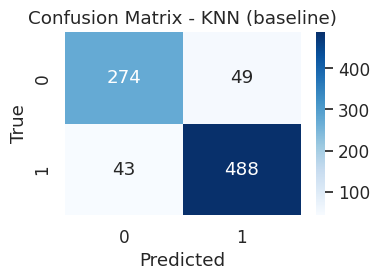

=== Decision Tree (baseline) ===
Accuracy : 0.9801
Precision: 0.9831
Recall   : 0.9849
F1-score : 0.9840

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       323
           1       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



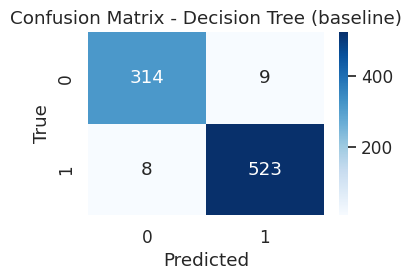

,model,accuracy,precision,recall,f1
0,KNN (baseline),0.892272,0.908752,0.919021,0.913858
1,Decision Tree (baseline),0.980094,0.983083,0.984934,0.984008


In [20]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

baseline_results = []
baseline_results.append(evaluate_model("KNN (baseline)", knn_pipeline, X_test, y_test))
baseline_results.append(evaluate_model("Decision Tree (baseline)", dt_pipeline, X_test, y_test))

pd.DataFrame(baseline_results)

In [21]:
# Hyperparameter tuning with GridSearchCV 


knn_param_grid = {
    "model__n_neighbors": [3, 5, 7, 9],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["minkowski", "manhattan"]
}

knn_grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

knn_grid_search.fit(X_train, y_train)

print("Best KNN params:", knn_grid_search.best_params_)
print("Best KNN CV F1:", knn_grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best KNN params: {'model__metric': 'manhattan', 'model__n_neighbors': 9, 'model__weights': 'distance'}
Best KNN CV F1: 0.9260997461212025


In [22]:
dt_param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [None, 3, 5, 7, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

dt_grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train, y_train)

print("Best DT params:", dt_grid_search.best_params_)
print("Best DT CV F1:", dt_grid_search.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best DT params: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Best DT CV F1: 0.9847234828752391


=== KNN (tuned) ===
Accuracy : 0.9040
Precision: 0.9134
Recall   : 0.9341
F1-score : 0.9236

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       323
           1       0.91      0.93      0.92       531

    accuracy                           0.90       854
   macro avg       0.90      0.89      0.90       854
weighted avg       0.90      0.90      0.90       854



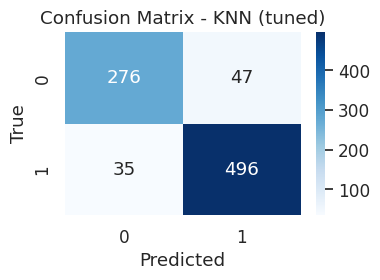

=== Decision Tree (tuned) ===
Accuracy : 0.9813
Precision: 0.9795
Recall   : 0.9906
F1-score : 0.9850

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



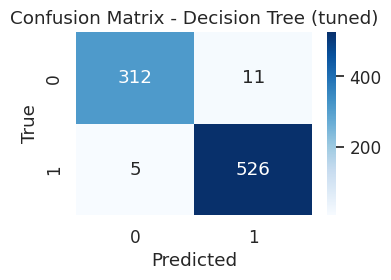

,model,accuracy,precision,recall,f1
0,KNN (baseline),0.892272,0.908752,0.919021,0.913858
1,Decision Tree (baseline),0.980094,0.983083,0.984934,0.984008
2,KNN (tuned),0.903981,0.913444,0.934087,0.923650
3,Decision Tree (tuned),0.981265,0.979516,0.990584,0.985019


In [29]:
# Again evaluate with tuned models

tuned_results = []

best_knn = knn_grid_search.best_estimator_
best_dt = dt_grid_search.best_estimator_

tuned_results.append(evaluate_model("KNN (tuned)", best_knn, X_test, y_test))
tuned_results.append(evaluate_model("Decision Tree (tuned)", best_dt, X_test, y_test))

results_df = pd.DataFrame(baseline_results + tuned_results)
results_df


We selected Decision Tree because it achieved the highest F1-score on the test set, balancing precision and recall.

In [25]:
# Use the best tuned Decision Tree pipeline
best_dt_model = best_dt

# Extract fitted preprocessor and tree model
fitted_preprocessor = best_dt_model.named_steps["preprocess"]
tree_clf = best_dt_model.named_steps["model"]

# Get feature names after preprocessing
feature_names = fitted_preprocessor.get_feature_names_out()
importances = tree_clf.feature_importances_

feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_importances.head(10)

,feature,importance
5,num__credit_score,0.765260
4,num__loan_term,0.132444
3,num__loan_amount,0.040867
2,num__income_annum,0.024222
7,num__commercial_assets_value,0.011559
6,num__residential_assets_value,0.011260
8,num__luxury_assets_value,0.008239
0,num__loan_id,0.003162
1,num__no_of_dependents,0.002020
9,num__bank_asset_value,0.000967


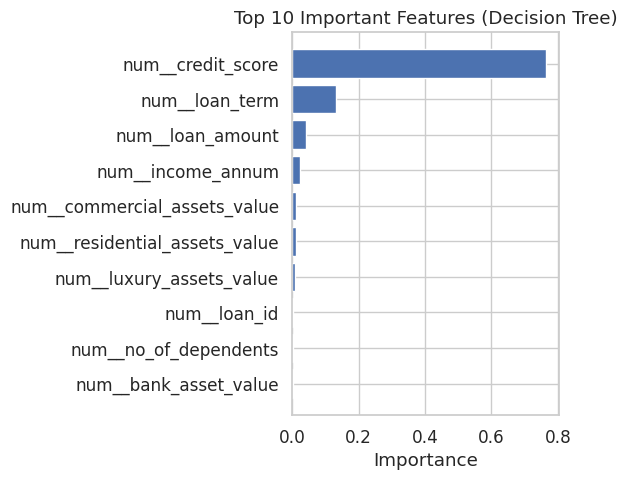

In [26]:
top_n = 10
top_features = feat_importances.head(top_n).sort_values("importance")

plt.figure(figsize=(6, 5))
plt.barh(top_features["feature"], top_features["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Important Features (Decision Tree)")
plt.tight_layout()
plt.show()

## Conclusion

- We built two models to predict loan approval:
  - K-Nearest Neighbors (KNN)
  - Decision Tree

- After hyperparameter tuning with 5-fold cross-validation, the best model was:
  - tuned Decision Tree
  - It achieved an F1-score of approximately **98.50%** on the test set.

- Feature importance analysis from the Decision Tree shows that:
  - credit score, loan term, loan amount, income
  - These features have the strongest influence on loan approval decisions.

- **Business insights** for the bank:
  - Applicants with higher credit scores and stable incomes are much more likely to be approved.
  - Very large loan amounts relative to income tend to lead to rejection.
  - The bank can use these insights to:
    - Refine its loan eligibility criteria,
    - Provide guidance to borderline applicants (e.g., improve credit score, adjust loan amount),
    - And design fairer, data-driven policies.
      